# Setup

- ADS: Carla garage (TP++)
- Repetitions: 1
- 132 sliced scenarios

# Loading data in one DF

In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path

pd.set_option('display.max_rows', 30)

In [2]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'index'])
    return df

In [3]:
def make_df(path: str):
    with open(path, "r") as f:
        path = path.strip("data/.json")
        print(path)
        it = iter(path.split("_"))
        data = dict(zip(it, it))

        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [4]:


dfs = []
path = "data/*.json"
for file_path in glob.glob(path):
    dfs.append(make_df(file_path))

df_combined = pd.concat(dfs)
# drop 30 fps
df_combined = df_combined.drop(labels=['30'], axis=0)
df_combined.info()

fps_20_highquality_True
fps_20_highquality_False
fps_10_highquality_False
fps_30_highquality_True
fps_18_highquality_True
fps_12_highquality_True
fps_14_highquality_True
fps_10_highquality_True
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 924 entries, ('20', 'True', 0) to ('10', 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           924 non-null    object 
 1   status                             924 non-null    object 
 2   infractions.collisions_layout      924 non-null    object 
 3   infractions.collisions_pedestrian  924 non-null    object 
 4   infractions.collisions_vehicle     924 non-null    object 
 5   infractions.outside_route_lanes    924 non-null    object 
 6   infractions.red_light              924 non-null    object 
 7   infractions.route_dev              924 non-null    object 
 8   infractions.route_timeou

/tmp/ipykernel_7278/2381262022.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_combined = df_combined.drop(labels=['30'], axis=0)


# Research questions


- RQ1: How does lowering the simulation's fidelity affect its execution time?
  - RQ1a: FPS impact on execution time
  - RQ1b: Rendering quality impact on execution time
- RQ2: How does lowering the simulation's fidelity affect evaluation results?
  - RQ2a: FPS impact on evaluation results
  - RQ2b: Rendering quality impact on evaluation results
- RQ3: How does lowering the simulation's fidelity affect using existing ADS testing techniques?


# Answering RQ1a & RQ2a

In [5]:
# take all rows where we were using high quality
df = df_combined.xs("True", level='highquality')
df = df.reset_index()

In [6]:
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    85.520782
18    86.529388
14    76.152762
12    60.303150
10    49.153971
Name: score_composed, dtype: float64

In [7]:
def plot(column: str):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker='s')
    axes.set_title(column.replace("_", " ").capitalize())
    return axes

Text(0.5, 1.0, 'Driving score, from 0 to 1')

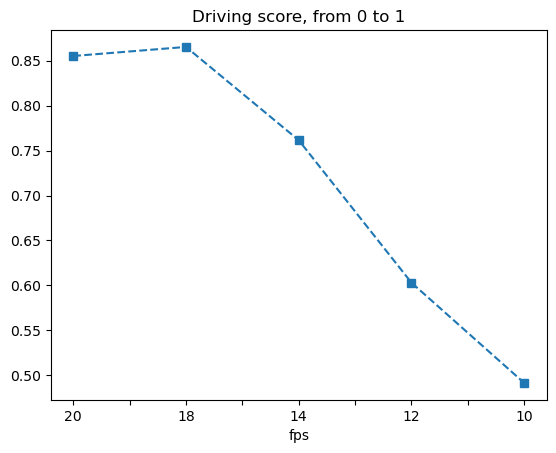

In [8]:
axes = plot("driving_score")
axes.set_title(f"Driving score, from 0 to 1")

(0.0, 267.608691187519)

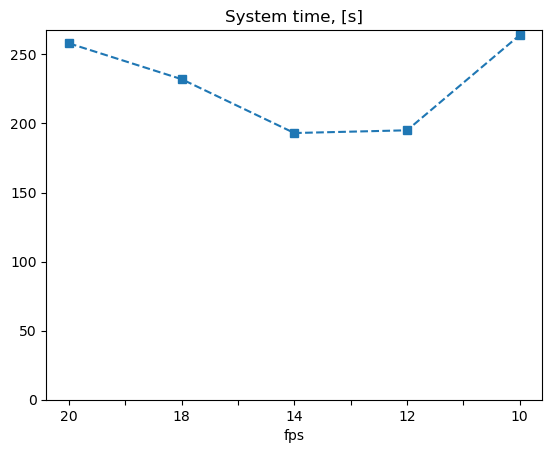

In [9]:
axes = plot("duration_system")
axes.set_title(f"System time, [s]")
axes.set_ylim(0)

# Prediction error

$\operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}\left(Y_{i}-{\hat {Y_{i}}}\right)^{2}$

/tmp/ipykernel_7278/3390102012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_error'] = (df['driving_score'] -


Text(0.5, 1.0, 'Driving score prediction RMSE\nroot mean square error')

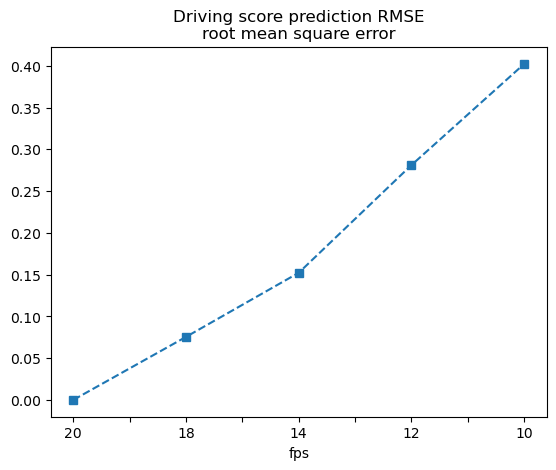

In [10]:
df = df_combined.xs("True", level='highquality')
oracle_df = df.xs(("20"),)

df['square_error'] = (df['driving_score'] -
                      oracle_df['driving_score']).pow(2).pow(1./2)


axes = plot("square_error")
axes.set_title(f"Driving score prediction RMSE\nroot mean square error")

# Answering RQ1b & RQ2b

Currently

- 20 EPIC, 20 LOW
- 10 EPIC, 10 LOW

In [11]:
from itertools import product

hq_vals = [True, False]
fps_vals = [20, 10]
df = pd.concat(
    [
        df_combined.xs((str(fps), str(hq)), drop_level=False)
        for (fps, hq) in product(fps_vals, hq_vals)
    ]).reset_index()

/tmp/ipykernel_7278/3889725737.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_combined.xs((str(fps), str(hq)), drop_level=False)


Text(0.5, 1.0, 'Score composed, from 0 to 100')

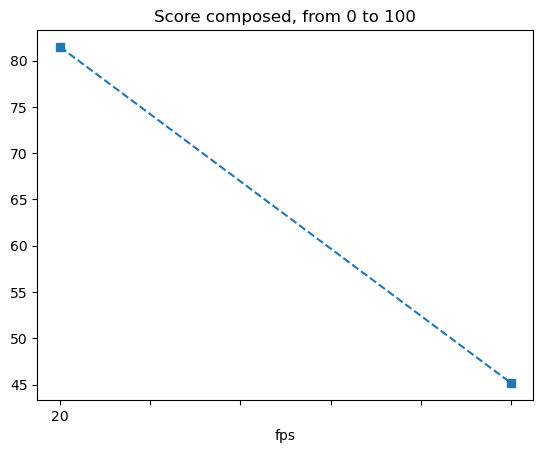

In [12]:

axes = plot("score_composed")
axes.set_title(f"{axes.get_title()}, from 0 to 100")

Text(0.5, 1.0, 'System time, [s]')

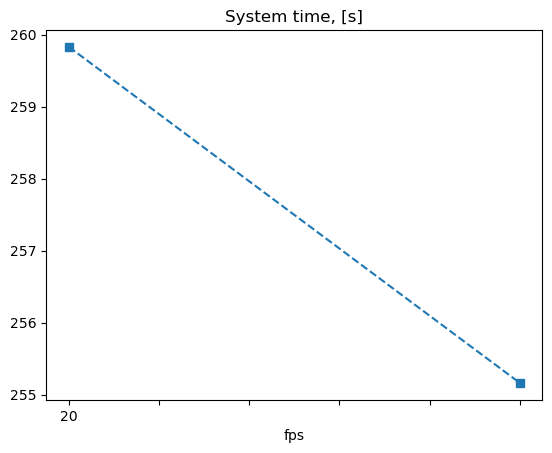

In [13]:
axes = plot("duration_system")
axes.set_title(f"System time, [s]")
# axes.set_ylim(0)